# Prediction intervals

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/306-prediction_intervals.ipynb)

This notebook contains overview of prediction intervals functionality in ETNA library.

**Table of contents**

* [Loading and preparing data](#chapter1)
* [Estimating intervals using builtin method](#chapter2)
    * [Accessing prediction intervals in TSDataset](#chapter2_1)
    * [Computing interval metrics](#chapter2_2)
* [Estimating prediction intervals using experimental.prediction_intervals module](#chapter3)
    * [NaiveVariancePredictionIntervals](#chapter3_1)
    * [ConformalPredictionIntervals](#chapter3_2)
    * [EmpiricalPredictionIntervals](#chapter3_3)
    * [Prediction intervals for ensembles](#chapter3_4)
* [Custom prediction interval method](#chapter4)
    * [Non-parametric method](#chapter4_1)
    * [Estimating historical residuals](#chapter4_2)

In [1]:
import warnings
from copy import deepcopy

import numpy as np
import pandas as pd

from etna.analysis.forecast import plot_forecast
from etna.datasets import TSDataset
from etna.metrics import Coverage
from etna.metrics import Width
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import SegmentEncoderTransform

warnings.filterwarnings("ignore")

In [2]:
HORIZON = 30

## 1. Loading and preparing data <a class="anchor" id="chapter1"></a>

Consider the dataset `data/example_dataset.csv`.

This data will be used to show how prediction intervals could be estimated and accessed in ETNA library.

The first step is to load data and convert it to the `TSDataset`.

In [3]:
df = pd.read_csv("data/example_dataset.csv")
df = TSDataset.to_dataset(df=df)
ts = TSDataset(df=df, freq="D")

ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384
...,...,...,...,...
2019-11-26,591,259,196,941
2019-11-27,606,264,196,949


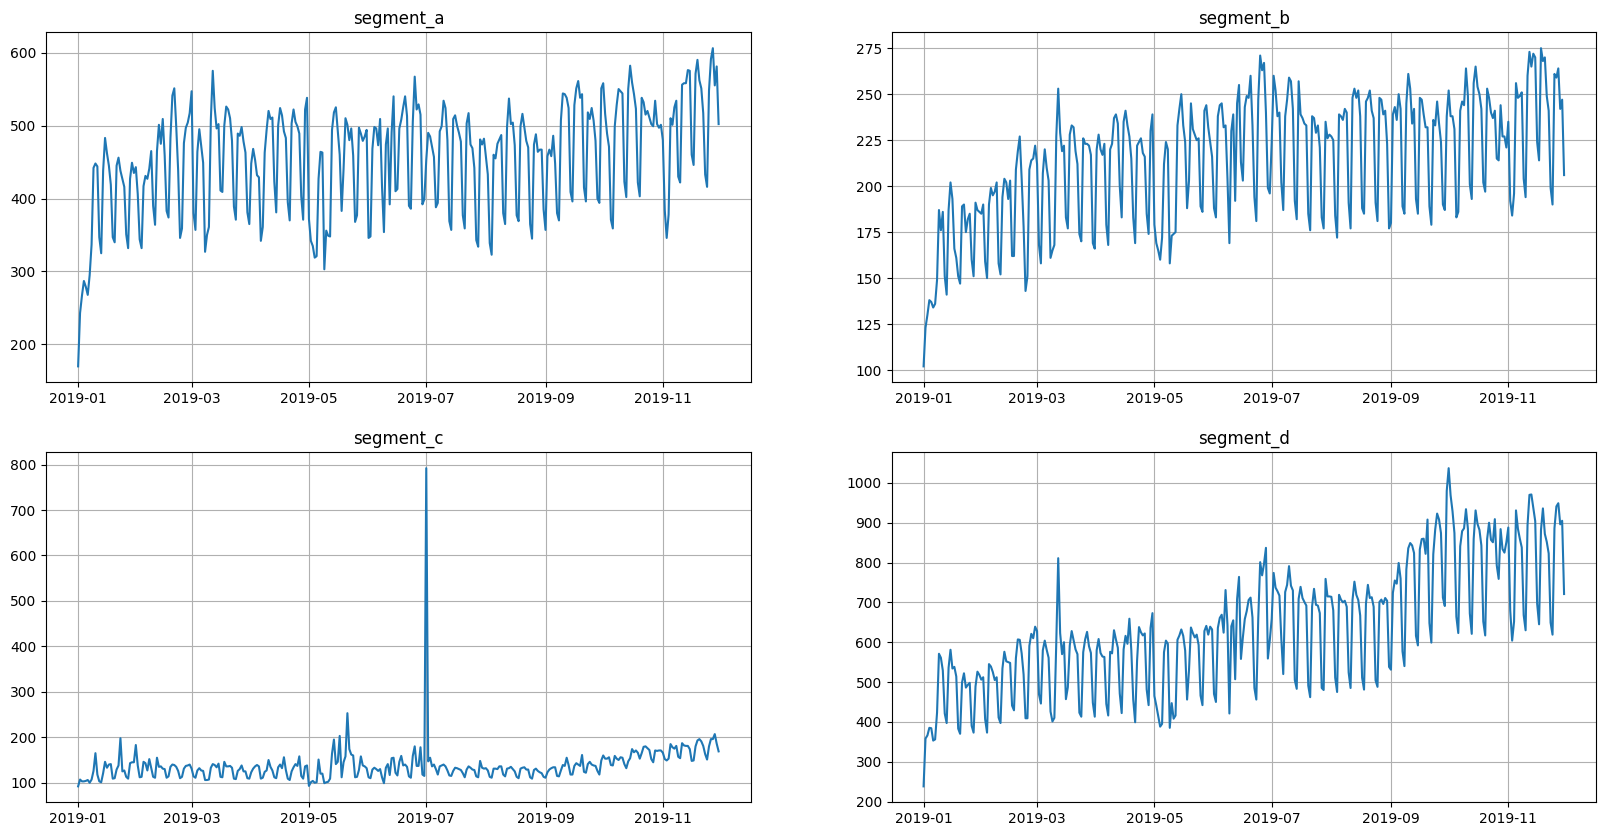

In [4]:
ts.plot()

Here we have four segments in the dataset. All segments have seasonalities, and some of them show signs of trend.
Note that segment C contains an obvious outlier, that may affect quality of estimated intervals.

In the next step, we split our dataset into two parts: train and test. The test part will be used as a hold-out dataset for metrics
computation and result analysis.

In [5]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

## 2. Estimating intervals using builtin method <a class="anchor" id="chapter2"></a>

Prediction interval is an estimation of the range in which a future observation will fall, with a certain probability,
given historical observations.

There are several ways of estimation: model-specific and model-agnostic methods. Model-specific methods use features
of underlying models, that are able to produce probabilistic estimates. Examples of such models are SARIMAX,
Holt-Winters and TBATS. Model-agnostic methods treat models as black boxes and implement separate methods to do the estimation.
The topic of this notebook is model-agnostic methods only.

Currently there are several types of prediction intervals in the library:
1. Quantiles estimates
2. Arbitrary interval borders, that tend to provide desired coverage

Quantiles estimation methods, implemented in the library, use univariate distribution to estimate quantiles at each timestamp in the horizon. There is the possibility of treating all
timestamps in the horizon jointly as multivariate random variable to estimate quantiles, but this approach is not implemented right now. The extension of current method pool will
be discussed in the last section of this notebook.

So there are some naming convention to achieve distinction between two types of intervals. Borders that approximate quantiles named using the following format `{target_{q:.4g}}`, where `q`
is the corresponding quantile level. And there are no particular rules for the arbitrary borders. But it is implementation
responsibility to name them appropriately.

Before estimating prediction intervals we need to fit a model. Here `CatBoostMultiSegmentModel` is used with lag and date features.
This model requires computed features, so we add corresponding transforms to the pipeline.

In [6]:
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 20 + HORIZON)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
    out_column="flag",
)

transforms = [lags, date_flags, seg]

In [7]:
model = CatBoostMultiSegmentModel()

In [8]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

pipeline.fit(ts=train_ts);

After the pipeline is defined and fitted, we are able to estimate prediction intervals with the default method. To do so
set the `prediction_interval=True` parameter of the `forecast` method.

This method is based on residual variance estimation and $z$-scores. Variance estimation is done via running
historical backtest on non-overlapping folds. Number of folds is controlled by the `n_folds` parameter.

In [9]:
forecast = pipeline.forecast(ts=train_ts, prediction_interval=True, n_folds=7)
forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elap

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

Here we have a point forecast for the full horizon, along with an estimated prediction interval for each segment.

The section below describes how one can perform manipulations with intervals in the dataset with forecasts.

### 2.1 Accessing prediction intervals in `TSDataset` <a class="anchor" id="chapter2_1"></a>

Column names for the estimated prediction intervals can be obtained using the `TSDataset.prediction_intervals_names` property.

In [10]:
forecast.prediction_intervals_names

('target_0.025', 'target_0.975')

Here segment names are omitted, because they share interval estimation method. So column names identical for all the segments.

A dataframe with prediction intervals for each segment can be obtained by using the `TSDataset.get_prediction_intervals()` method.

Here, we save such dataframe to a separate object to use later.

In [11]:
prediction_intervals = forecast.get_prediction_intervals()
prediction_intervals

segment       segment_a                 segment_b                 segment_c  \
feature    target_0.025 target_0.975 target_0.025 target_0.975 target_0.025   
timestamp                                                                     
2019-11-01   470.753353   654.622675   182.998175   287.116897    33.867819   
2019-11-02   339.787734   523.657056   137.674295   241.793017     5.273997   
2019-11-03   328.057195   511.926517   136.459431   240.578153     8.896867   
2019-11-04   464.257076   648.126398   193.140438   297.259160    41.574061   
2019-11-05   471.667537   655.536859   197.889160   302.007882    46.067009   
2019-11-06   458.729249   642.598571   189.420442   293.539164    44.816511   
2019-11-07   477.280688   661.150010   197.562499   301.681221    46.092846   
2019-11-08   474.032182   657.901504   189.213408   293.332130    48.396520   
2019-11-09   342.156468   526.025790   145.463552   249.582274    19.344079   
2019-11-10   335.175499   519.044821   143.336403   247.455125    17.194591   
2019-11-11   488.455591   672.324913   202.226734   306.345456    52.974858   
2019-11-12   483.315864   667.185186   203.543648   307.662371    55.758080   
2019-11-13   466.986283   650.855605   194.021186   298.139908    50.141150   
2019-11-14   487.949334   671.818656   199.896469   304.015191    52.315531   
2019-11-15   482.792684   666.662006   193.939262   298.057985    61.206762   
2019-11-16   341.268023   525.137344   149.079266   253.197988    23.712223   
2019-11-17   342.778361   526.647683   152.365006   256.483728    30.379443   
2019-11-18   479.061701   662.931023   202.628841   306.747563    62.492294   
2019-11-19   499.022561   682.891883   198.347958   302.466681    57.142646   
2019-11-20   479.542225   663.411547   203.284886   307.403608    54.747406   
2019-11-21   481.230732   665.100054   205.877484   309.996207    63.412175   
2019-11-22   464.535473   648.404795   190.887708   295.006430    62.151579   
2019-11-23   346.853867   530.723188   159.171331   263.290053    32.471348   
2019-11-24   343.750821   527.620143   157.939006   262.057728    34.721080   
2019-11-25   492.355361   676.224683   212.837537   316.956260    80.679910   
2019-11-26   495.916553   679.785875   212.490423   316.609145    72.072010   
2019-11-27   503.081899   686.951221   216.030382   320.149104    83.249364   
2019-11-28   504.440254   688.309575   209.345608   313.464330    80.577678   
2019-11-29   495.299379   679.168701   199.689472   303.808194    76.070869   
2019-11-30   379.529016   563.398338   148.540798   252.659521    37.882227   

segment                    segment_d               
feature    target_0.975 target_0.025 target_0.975  
timestamp                                          
2019-11-01   260.423229   733.931966  1035.848293  
2019-11-02   231.829407   615.582631   917.498959  
2019-11-03   235.452277   584.317106   886.233433  
2019-11-04   268.129472   720.127906  1022.044233  
2019-11-05   272.622419   703.699278  1005.615606  
2019-11-06   271.371921   695.040362   996.956690  
2019-11-07   272.648256   712.042180  1013.958507  
2019-11-08   274.951930   735.060480  1036.976807  
2019-11-09   245.899489   635.712965   937.629293  
2019-11-10   243.750001   619.184829   921.101157  
2019-11-11   279.530268   732.067932  1033.984259  
2019-11-12   282.313490   716.594324  1018.510651  
2019-11-13   276.696560   699.892556  1001.808883  
2019-11-14   278.870942   715.197738  1017.114066  
2019-11-15   287.762172   740.728216  1042.644543  
2019-11-16   250.267633   644.504240   946.420567  
2019-11-17   256.934853   643.145934   945.062262  
2019-11-18   289.047705   718.121574  1020.037902  
2019-11-19   283.698056   704.219583  1006.135911  
2019-11-20   281.302817   699.971896  1001.888223  
2019-11-21   289.967586   719.320619  1021.236946  
2019-11-22   288.706989   739.286843  1041.203170  
2019-11-23   259.026758   624.928425   926.844753  
2019-11-24   261.276491   600.075611   9

If estimated intervals are no longer needed or there is a necessity to remove prediction intervals from the dataset use
`TSDataset.drop_prediction_intervals()` method.

In [12]:
forecast.drop_prediction_intervals()
forecast.prediction_intervals_names

()

Here we see that property contains an empty tuple now. It is an indication that no intervals are registered.

In [13]:
forecast.get_prediction_intervals()

Calling `TSDataset.get_prediction_intervals()` in such a case will return `None`.

There is a possibility of adding existing prediction intervals to the dataset. To do so, one should use
`TSDataset.add_prediction_intervals()` method.

There are a couple requirements when adding existing intervals to the dataset.
1. Absence of the intervals in the dataset. This could be checked via the `prediction_intervals_names` property.
2. The dataframe with intervals should be in ETNA wide format.
3. All segments should be matched between the dataset and intervals dataframe.
4. Interval borders names are matched across all the segments.

In [14]:
forecast.add_prediction_intervals(prediction_intervals_df=prediction_intervals)
forecast.prediction_intervals_names

('target_0.025', 'target_0.975')

In [15]:
forecast

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

We called `prediction_intervals_names` here to ensure that intervals were correctly added and printed out the resulting dataset.

Results visualization could be done using the `plot_forecast` function. Setting parameter `prediction_intervals=True` will
enable plotting estimated prediction intervals.

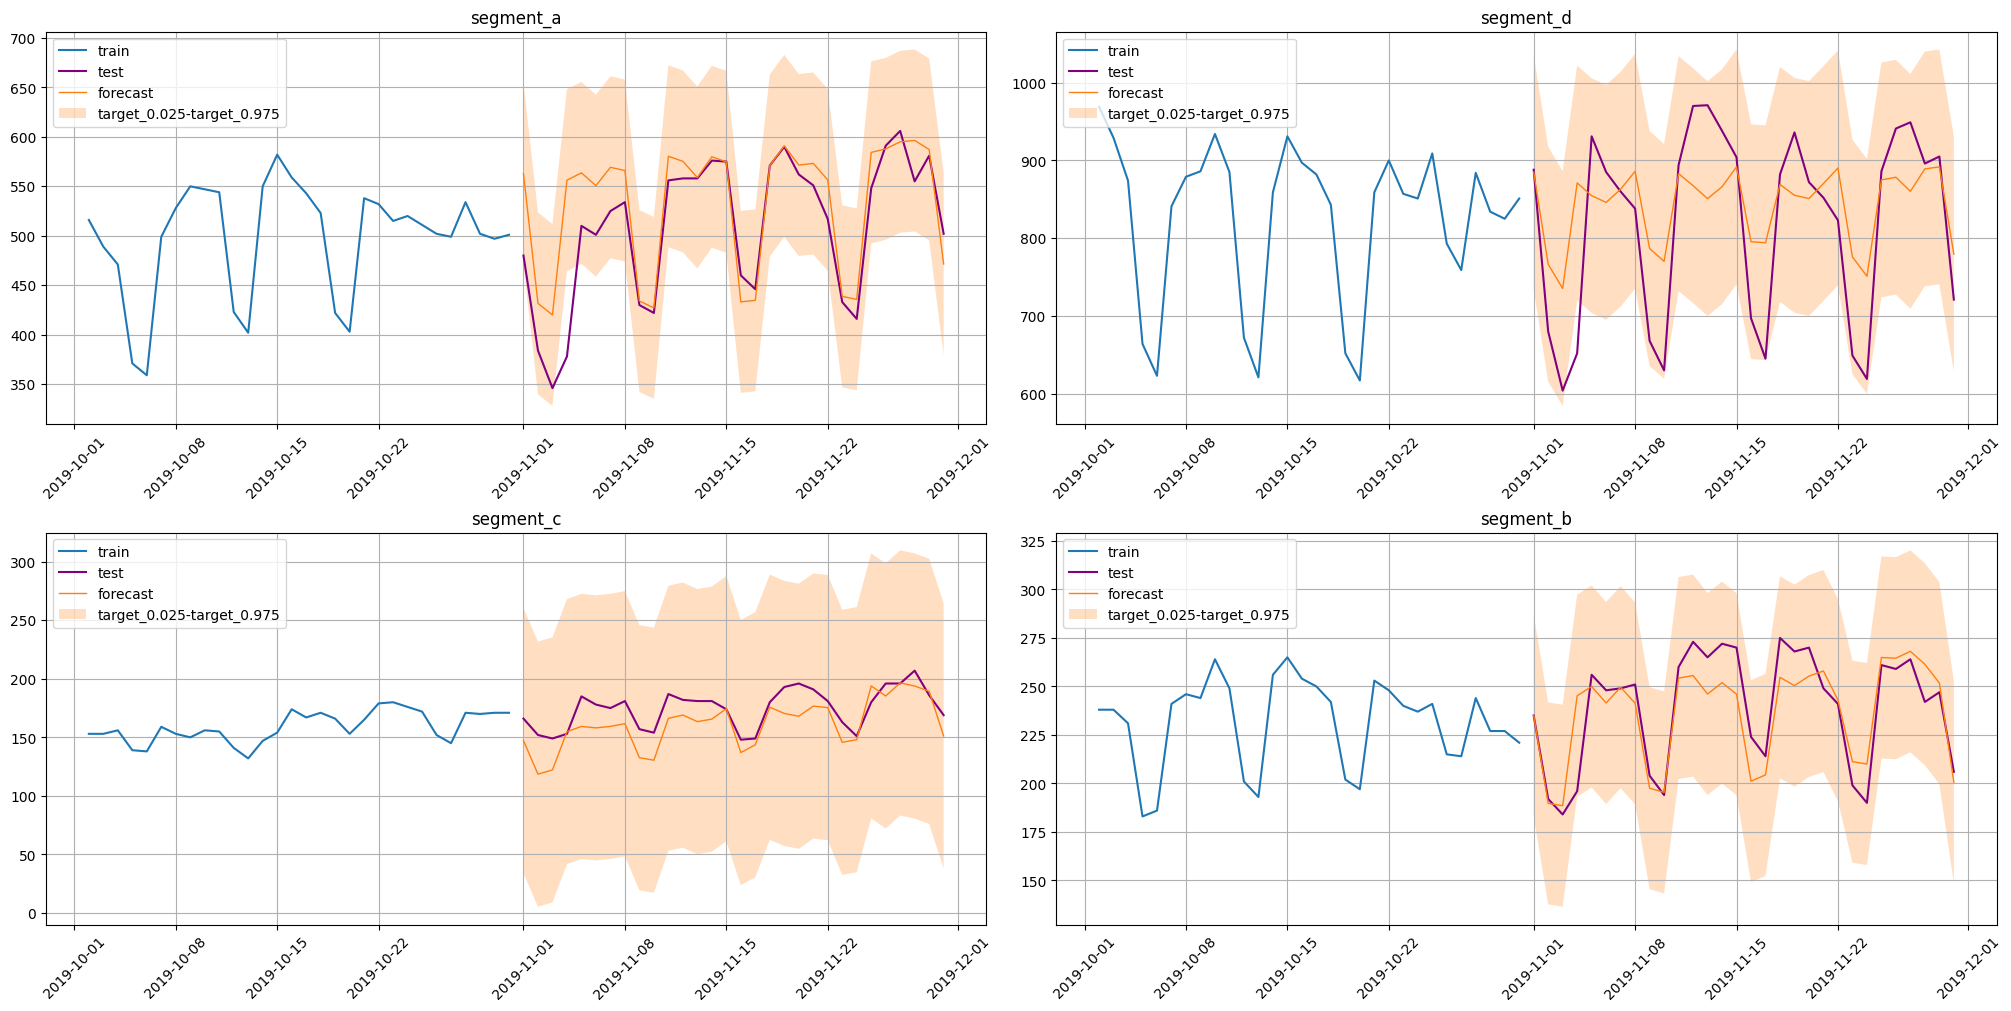

In [16]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

### 2.2 Computing interval metrics <a class="anchor" id="chapter2_2"></a>

There are a couple of metrics in the library that can help estimate the quality of computed prediction intervals:
* `Coverage` - percentage of points in the horizon that fall between interval borders
* `Width` - mean distance between intervals borders at each timestamp of the horizon.

These metrics require initialization. To specify which interval to use provide border names by setting
`lower_name` and `upper_name` parameters. After initialization these metrics will try to find specified borders in
the dataset with predicted values. If provided names are not found, a corresponding error will be raised.

If estimated intervals borders are quantiles desired levels could be selected by setting the `quantiles` parameter. Usage of both ways of interval selection will lead to an error.

Here we wrap metrics estimation in one function.

In [17]:
def interval_metrics(test_ts, forecast):
    lower_name, upper_name = forecast.prediction_intervals_names

    coverage = Coverage(lower_name=lower_name, upper_name=upper_name)(test_ts, forecast)
    width = Width(lower_name=lower_name, upper_name=upper_name)(test_ts, forecast)

    return coverage, width

In [18]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [19]:
coverage

{'segment_a': 0.9666666666666667,
 'segment_b': 1.0,
 'segment_c': 1.0,
 'segment_d': 0.9666666666666667}

In [20]:
width

{'segment_a': 183.8693219098439,
 'segment_b': 104.11872216880786,
 'segment_c': 226.55541023779915,
 'segment_d': 301.9163274096744}

## 3. Estimating prediction intervals using `experimental.prediction_intervals` module <a class="anchor" id="chapter3"></a>

The ETNA library provides several alternative methods for prediction interval estimation. All necessary functionality is
in the `etna.experimental.prediction_intervals` module.

This section covers currently implemented methods. Also, the module provides the possibility to easily extend the method list by implementing a custom one.
This topic will be discussed in the last section.

Prediction interval functionality is implemented via wrapper classes for the ETNA pipelines. During initialization,
such methods require pipeline instances and necessary hyperparameters. Provided pipeline can be fitted before or after wrapping with the interval estimation method.

### 3.1 `NaiveVariancePredictionIntervals` <a class="anchor" id="chapter3_1"></a>

This method estimates prediction quantiles using the following algorithm:

1. Compute the residuals matrix $r_{it} = \hat y_{it} - y_{it}$ using k-fold backtest, where $i$ is fold index.

2. Estimate variance for each step in the prediction horizon $v_t = \frac{1}{k} \sum_{i = 1}^k r_{it}^2$.

3. Use $z$-scores and estimated variance to compute corresponding quantiles.


Desired quantiles levels for the prediction interval can be set via `quantiles` of the `forecast` method.

In [21]:
from etna.experimental.prediction_intervals import NaiveVariancePredictionIntervals

pipeline = NaiveVariancePredictionIntervals(pipeline=pipeline)

forecast = pipeline.forecast(quantiles=(0.025, 0.975), prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   38.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   43.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

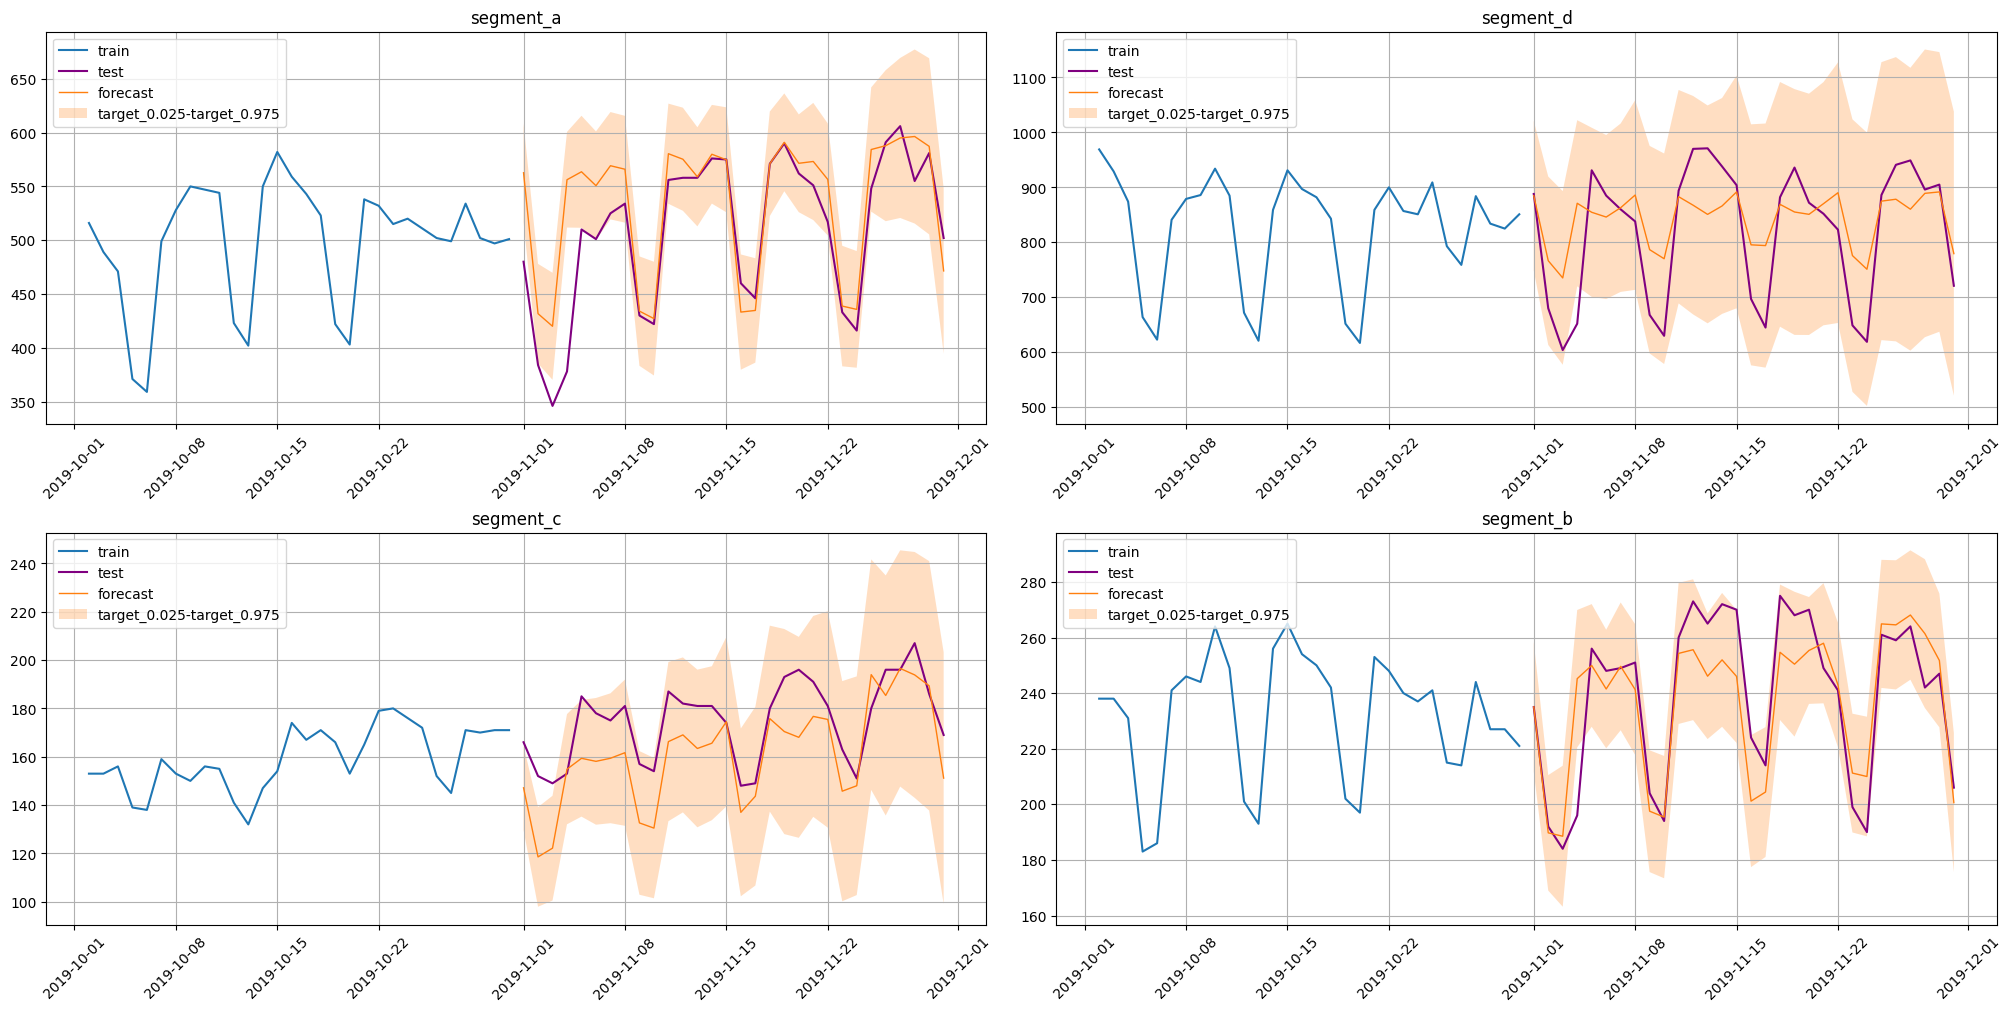

In [22]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [23]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [24]:
coverage

{'segment_a': 0.8333333333333334,
 'segment_b': 0.9333333333333333,
 'segment_c': 0.8666666666666667,
 'segment_d': 0.9666666666666667}

In [25]:
width

{'segment_a': 108.50105291374686,
 'segment_b': 46.55147330372556,
 'segment_c': 72.3575509237814,
 'segment_d': 414.01584353697956}

### 3.2 `ConformalPredictionIntervals` <a class="anchor" id="chapter3_2"></a>

Estimates conformal prediction intervals:

1. Compute matrix of absolute residuals  $r_{it} = |\hat y_{it} - y_{it}|$ using k-fold historical backtest, where $i$ is fold index.

2. Estimate corresponding quantiles levels using the provided coverage (e.g. apply Bonferroni correction).

3. Estimate quantiles for each horizon step separately using computed absolute residuals and levels.


**Note**: this method estimates arbitrary interval bounds that tend to provide a given coverage rate.
So this method ignores the `quantiles` parameter of the `forecast` method.

Coverage rate and correction option should be set at the method initialization step.

In [26]:
from etna.experimental.prediction_intervals import ConformalPredictionIntervals

pipeline = ConformalPredictionIntervals(pipeline=pipeline, coverage=0.95, bonferroni_correction=True)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   39.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   46.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

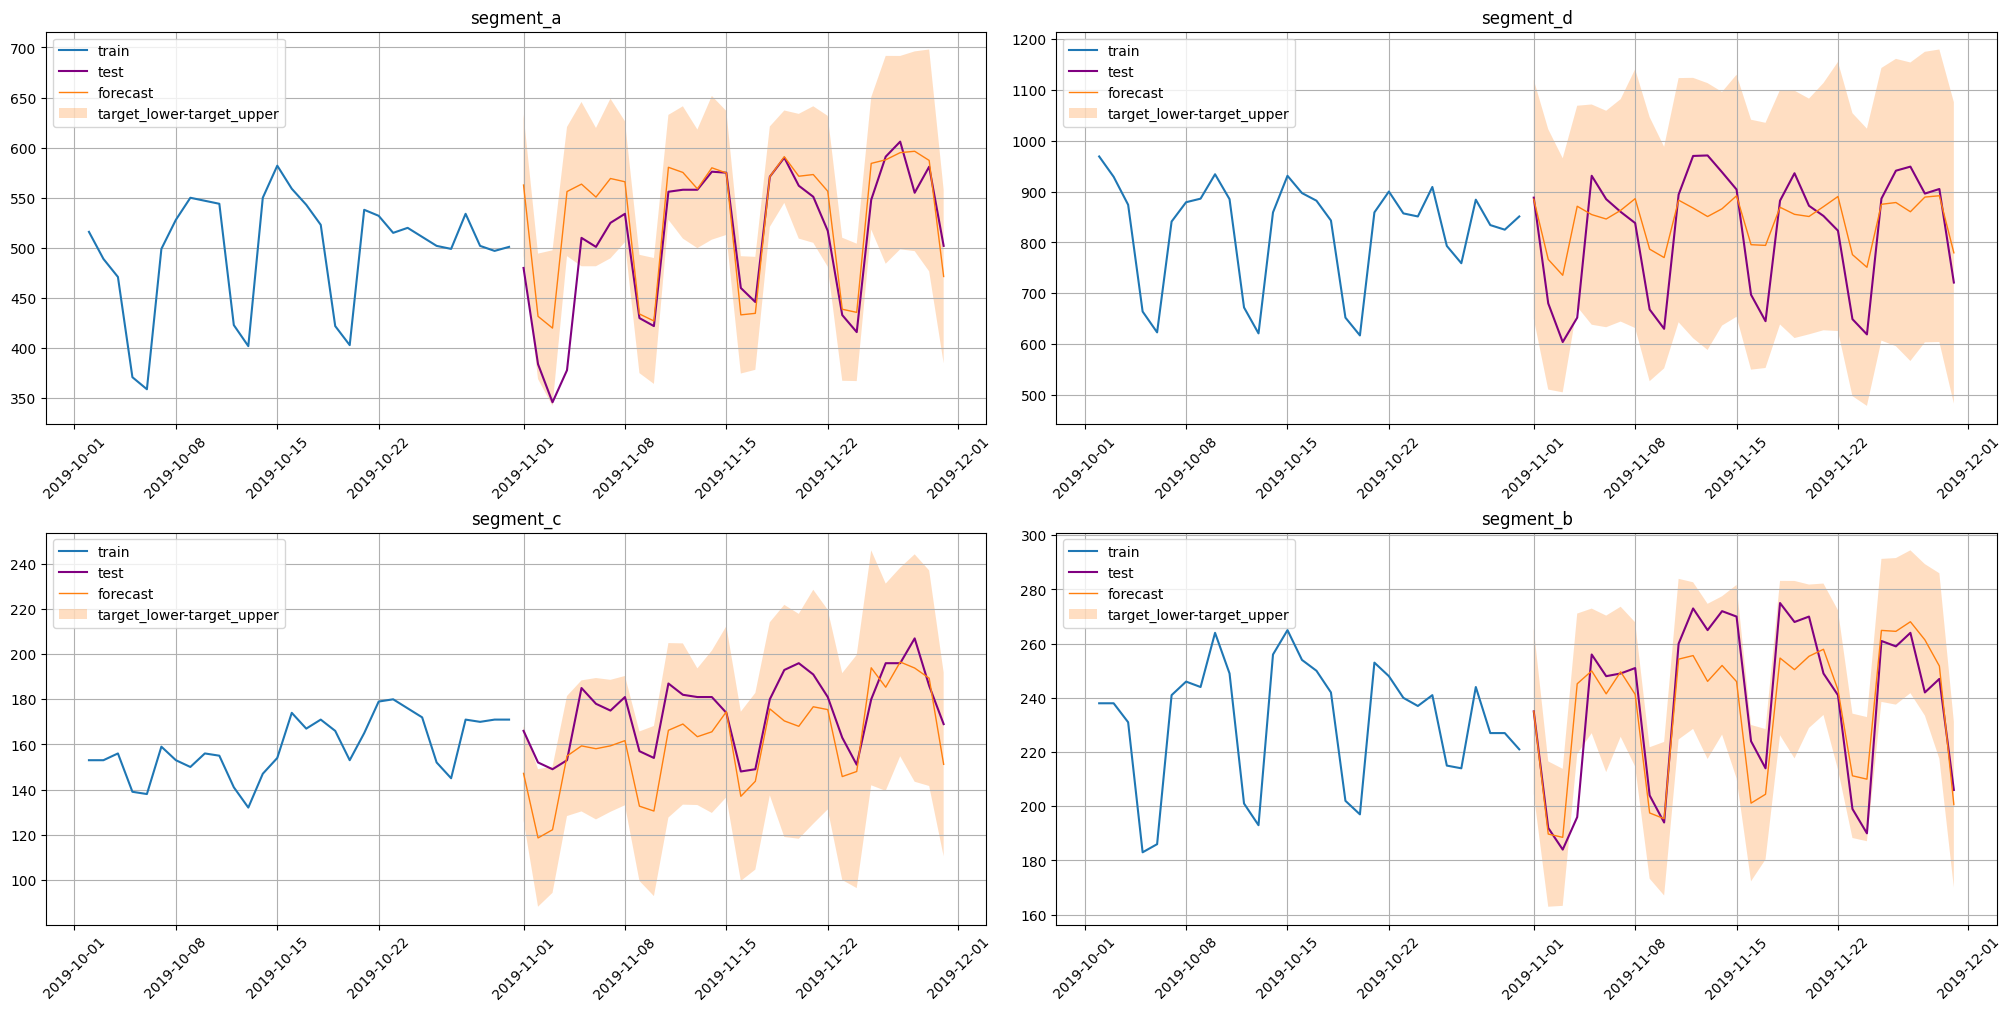

In [27]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [28]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [29]:
coverage

{'segment_a': 0.9333333333333333,
 'segment_b': 0.9666666666666667,
 'segment_c': 0.9666666666666667,
 'segment_d': 0.9666666666666667}

In [30]:
width

{'segment_a': 141.19971750106404,
 'segment_b': 54.86083262147848,
 'segment_c': 77.48869154071357,
 'segment_d': 499.4061536460892}

### 3.3 `EmpiricalPredictionIntervals` <a class="anchor" id="chapter3_3"></a>

Estimates prediction intervals via historical residuals:

1. Compute matrix of residuals $r_{it} = |\hat y_{it} - y_{it}|$ using k-fold backtest, where $i$ is fold index.

2. Estimate quantiles levels, that satisfy the provided coverage, for the corresponding residuals distributions.

3. Estimate quantiles for each timestamp using computed residuals and levels.


**Note**: this method estimates arbitrary interval bounds that tend to provide a given coverage rate.
So this method ignores the `quantiles` parameter of the `forecast` method.

Coverage rate and correction option should be set at method initialization step.

In [31]:
from etna.experimental.prediction_intervals import EmpiricalPredictionIntervals

pipeline = EmpiricalPredictionIntervals(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   53.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBac

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

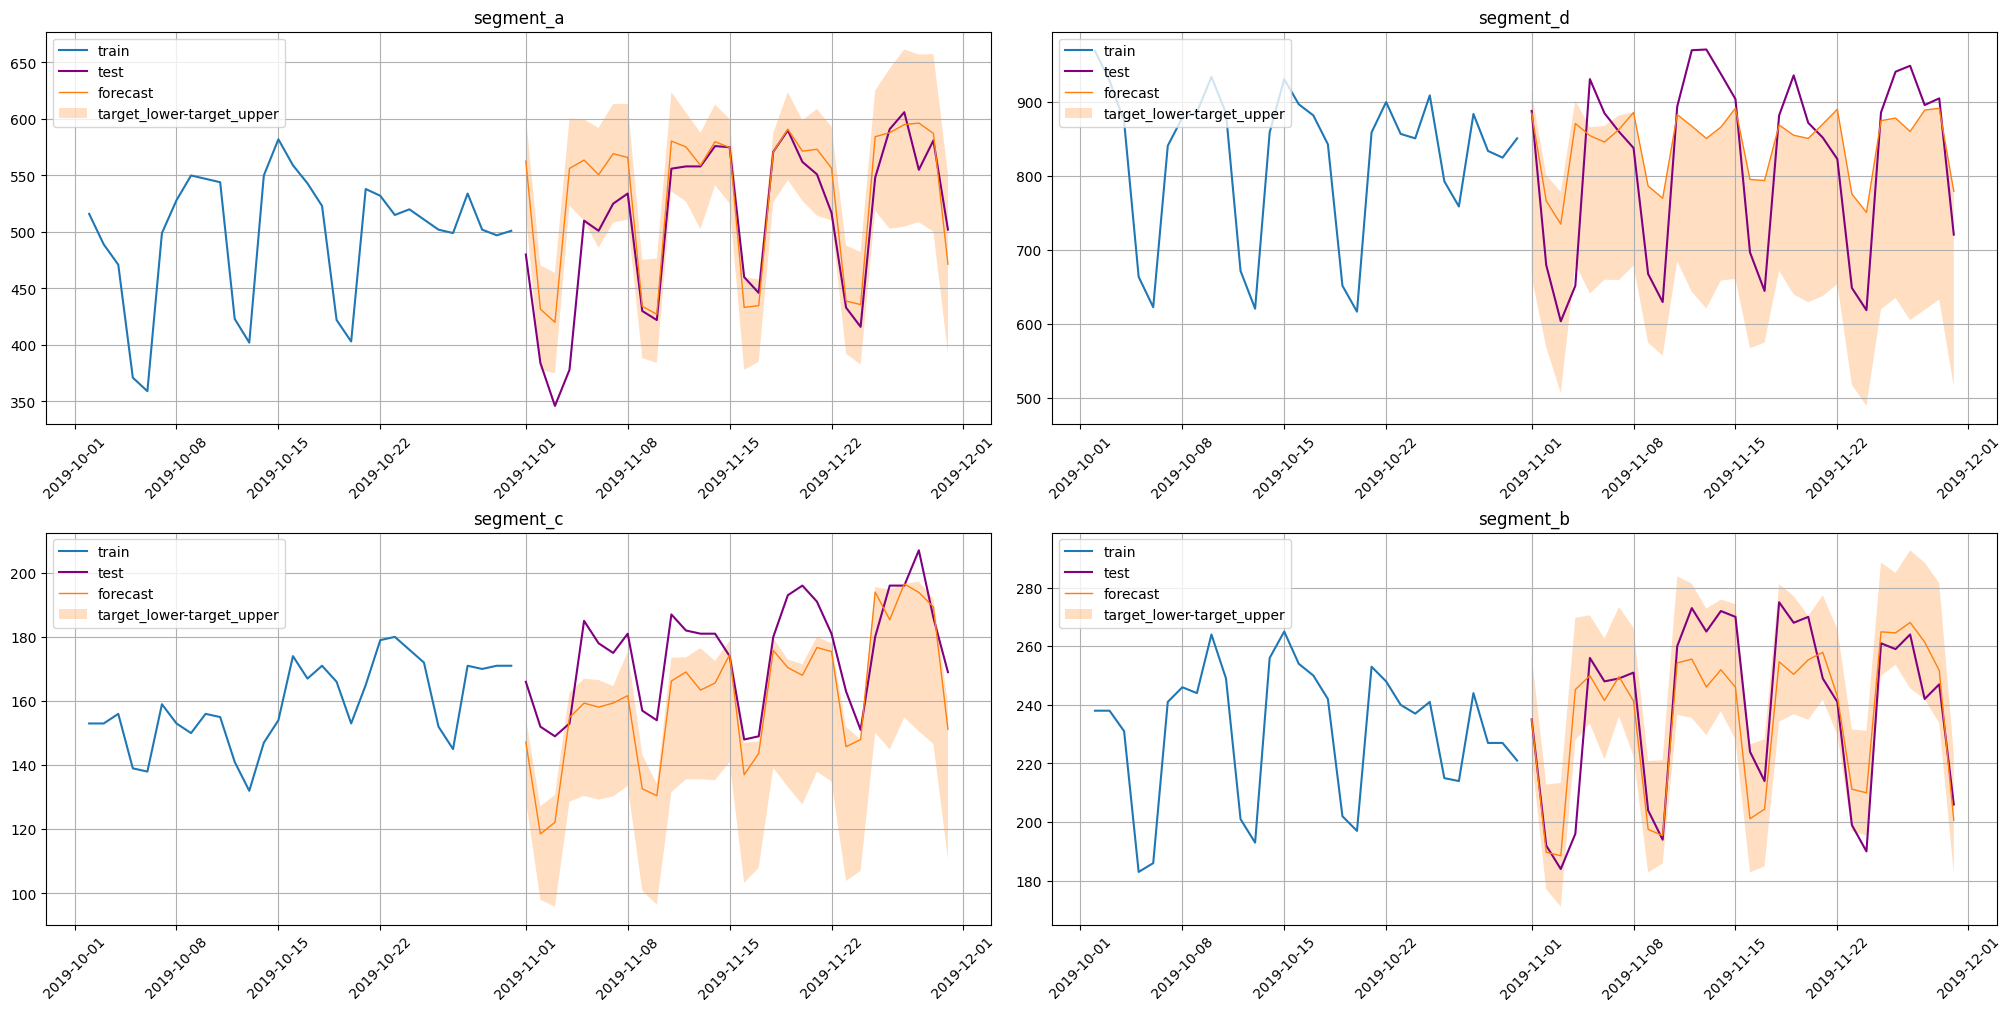

In [32]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [33]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [34]:
coverage

{'segment_a': 0.8666666666666667,
 'segment_b': 0.9333333333333333,
 'segment_c': 0.16666666666666666,
 'segment_d': 0.4666666666666667}

In [35]:
width

{'segment_a': 97.76013455528955,
 'segment_b': 40.370329153680345,
 'segment_c': 40.2553666590423,
 'segment_d': 231.97320117702435}

### 3.4 Prediction intervals for ensembles <a class="anchor" id="chapter3_4"></a>

Pipeline ensembles could be passed to interval methods as well.

Consider a short usage example with `VotingEnsemble`.

In [36]:
from etna.ensembles import VotingEnsemble

ensemble = VotingEnsemble(pipelines=[deepcopy(pipeline), deepcopy(pipeline)])
ensemble = NaiveVariancePredictionIntervals(pipeline=ensemble, stride=HORIZON)

forecast = pipeline.forecast(prediction_interval=True, n_folds=5)

forecast.prediction_intervals_names

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

('target_lower', 'target_upper')

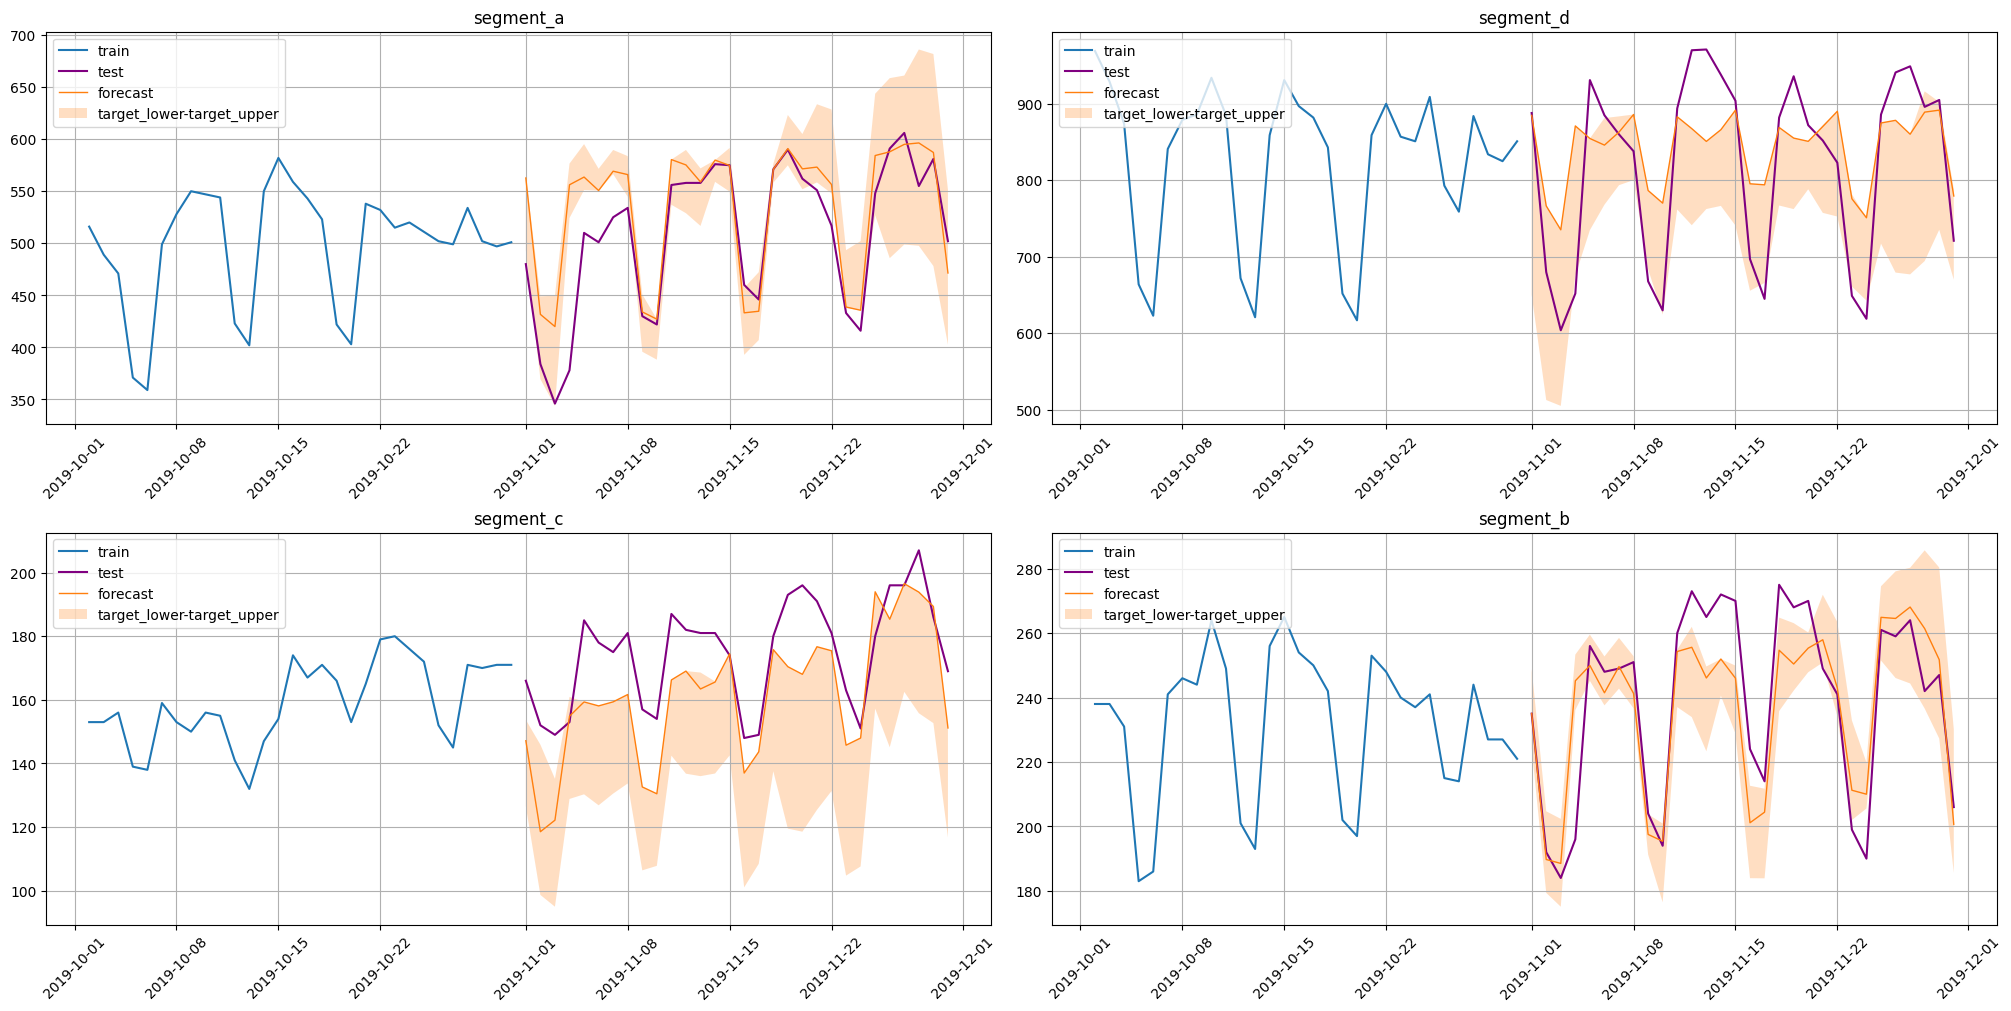

In [37]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

## 4. Custom prediction interval method <a class="anchor" id="chapter4"></a>

There is a possibility in the library to extend the set of prediction intervals methods by implementing the desired algorithm.
This section demonstrates how it can be done. Examples of interface and utilities usage are provided as well.

`BasePredictionIntervals` - base class for prediction intervals methods.

This class implements a wrapper interface for pipelines and ensembles that provides the ability to estimate prediction intervals.
So it requires a pipeline instance to be provided to the `__init__` method for proper initialization.

To add a particular method for pipelines, one must inherit from this class and provide an implementation for
the abstract method ``_forecast_prediction_interval``. This method should estimate and store prediction intervals for out-of-sample forecasts.

**Limitations**
In-sample prediction is not supported by default and will raise a corresponding error while attempting to do so.
This functionality could be implemented if needed by overriding the ``_predict`` method, which is responsible for building
an in-sample point forecast and adding prediction intervals.

### 4.1 Non-parametric method <a class="anchor" id="chapter4_1"></a>

The example below demonstrates how the interval method could be implemented.

Consider `ConstantWidthInterval`, which simply adds constant `width` to a point forecast. Here `width` is a hyperparameter that
will be set on the method initialization step.

In [38]:
from typing import Sequence

from etna.experimental.prediction_intervals import BasePredictionIntervals
from etna.pipeline import BasePipeline

In [39]:
class ConstantWidthInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, interval_width: float):
        assert interval_width > 0

        self.interval_width = interval_width
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        predicted_target = predictions[..., "target"]

        lower_border = predicted_target - self.interval_width / 2
        upper_border = predicted_target + self.interval_width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [40]:
pipeline = ConstantWidthInterval(pipeline=pipeline, interval_width=150)

forecast = pipeline.forecast(prediction_interval=True, n_folds=40)

forecast

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

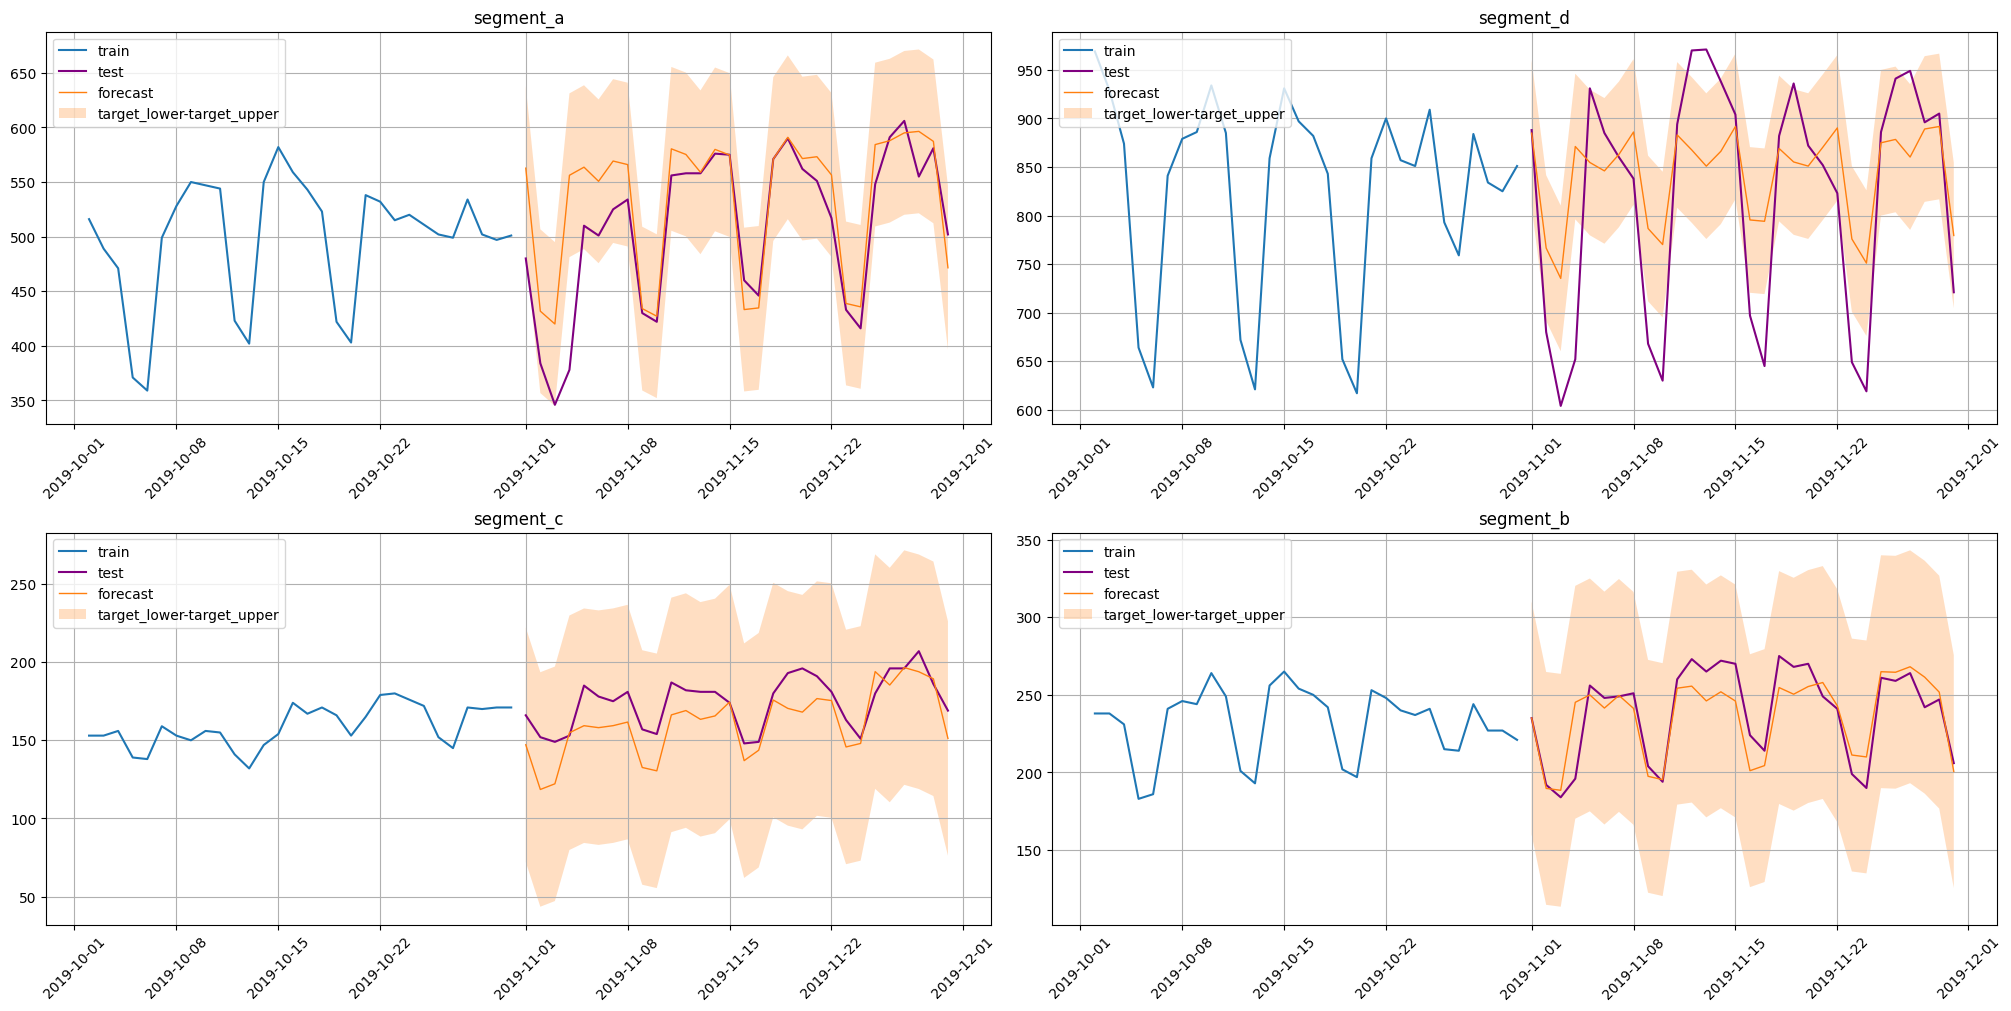

In [41]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [42]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [43]:
coverage

{'segment_a': 0.9333333333333333,
 'segment_b': 1.0,
 'segment_c': 1.0,
 'segment_d': 0.5333333333333333}

In [44]:
width

{'segment_a': 150.0,
 'segment_b': 150.0,
 'segment_c': 150.0,
 'segment_d': 150.0}

### 4.2 Estimating historical residuals <a class="anchor" id="chapter4_2"></a>

Some prediction intervals methods require doing historical forecasts. This could be done by using the pipeline's `get_historical_forecasts` method.
As `BasePredictionIntervals` wraps pipelines, this method is implemented here as well.

Consider the example `MaxAbsResidInterval`. This method estimates intervals based on the maximum
absolute values of historical residuals for each segment. So we can break down this algorithm into the following steps:

1. Estimate historical forecasts by calling the `get_historical_forecasts` method.
2. For each `segment` estimate residuals, find the maximum absolute value and add to the point forecast.

In [45]:
class MaxAbsResidInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, coverage: float = 0.95, stride: int = 1):
        assert stride > 0
        assert 0 < coverage <= 1

        self.stride = stride
        self.coverage = coverage
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        predicted_target = predictions[..., "target"]

        lower_border = predicted_target.copy()
        upper_border = predicted_target.copy()

        fold_forecast = self.get_historical_forecasts(ts=ts, n_folds=n_folds, stride=self.stride)

        for segment in ts.segments:
            residuals = (
                ts.loc[:, pd.IndexSlice[segment, "target"]] - fold_forecast.loc[:, pd.IndexSlice[segment, "target"]]
            )
            width = np.max(np.abs(residuals))

            lower_border.loc[:, pd.IndexSlice[segment, "target"]] -= self.coverage * width / 2
            upper_border.loc[:, pd.IndexSlice[segment, "target"]] += self.coverage * width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [46]:
pipeline = MaxAbsResidInterval(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=5)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

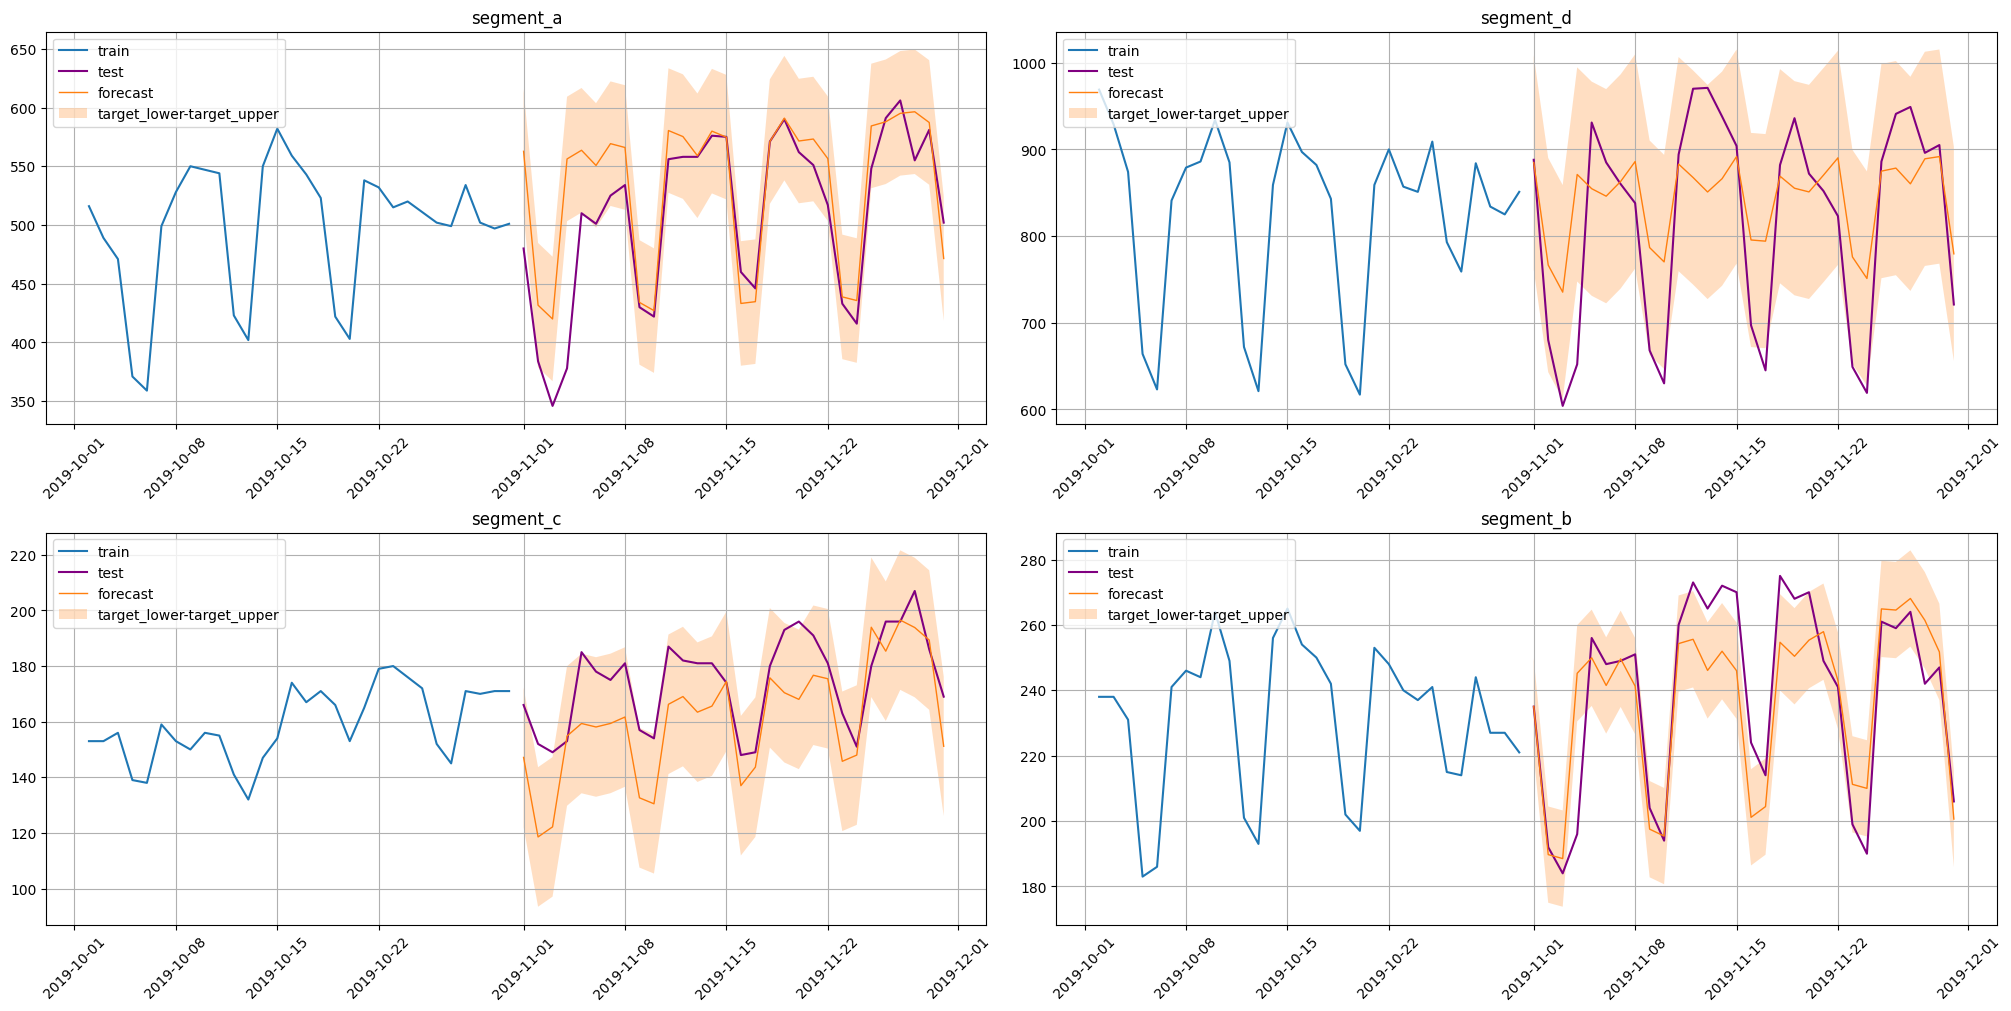

In [47]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [48]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [49]:
coverage

{'segment_a': 0.8666666666666667,
 'segment_b': 0.6666666666666666,
 'segment_c': 0.8666666666666667,
 'segment_d': 0.8}

In [50]:
width

{'segment_a': 106.01589052275085,
 'segment_b': 29.46380276236236,
 'segment_c': 50.17717248209039,
 'segment_d': 247.16834782574568}

Obtaining historical residuals for prediction intervals estimation can be
simplified by using the more efficient utility function `residuals_matrices`.
This function accepts pipeline, data, parameters for backtest and computes residuals
for each segment on every fold.

**Note** that `residuals_matrices` function returns a 3 dimensional array with axes sizes `(num_folds, horizon, num_segments)`.

Here we use this function to optimize the proposed method. Consider `OptimizedMaxAbsResidInterval`.

In [51]:
from etna.experimental.prediction_intervals.utils import residuals_matrices


class OptimizedMaxAbsResidInterval(BasePredictionIntervals):
    def __init__(self, pipeline: BasePipeline, coverage: float = 0.95, stride: int = 1):
        assert stride > 0
        assert 0 < coverage <= 1

        self.stride = stride
        self.coverage = coverage
        super().__init__(pipeline=pipeline)

    def _forecast_prediction_interval(
        self, ts: TSDataset, predictions: TSDataset, quantiles: Sequence[float], n_folds: int
    ) -> TSDataset:
        residuals = residuals_matrices(pipeline=self, ts=ts, n_folds=n_folds, stride=self.stride)

        predicted_target = predictions[..., "target"]

        width = np.max(np.abs(residuals), axis=(0, 1)).reshape(1, -1)

        lower_border = predicted_target - self.coverage * width / 2
        upper_border = predicted_target + self.coverage * width / 2

        upper_border.rename({"target": "target_upper"}, inplace=True, axis=1)
        lower_border.rename({"target": "target_lower"}, inplace=True, axis=1)

        predictions.add_prediction_intervals(prediction_intervals_df=pd.concat([lower_border, upper_border], axis=1))
        return predictions

In [52]:
pipeline = OptimizedMaxAbsResidInterval(pipeline=pipeline)

forecast = pipeline.forecast(prediction_interval=True, n_folds=3)

forecast

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

segment                   segment_a                                          \
feature    flag_day_number_in_month flag_day_number_in_week flag_is_weekend   
timestamp                                                                     
2019-11-01                        1                       4           False   
2019-11-02                        2                       5            True   
2019-11-03                        3                       6            True   
2019-11-04                        4                       0           False   
2019-11-05                        5                       1           False   
2019-11-06                        6                       2           False   
2019-11-07                        7                       3           False   
2019-11-08                        8                       4           False   
2019-11-09                        9                       5            True   
2019-11-10                       10                       6            True   
2019-11-11                       11                       0           False   
2019-11-12                       12                       1           False   
2019-11-13                       13                       2           False   
2019-11-14                       14                       3           False   
2019-11-15                       15                       4           False   
2019-11-16                       16                       5            True   
2019-11-17                       17                       6            True   
2019-11-18                       18                       0           False   
2019-11-19                       19                       1           False   
2019-11-20                       20                       2           False   
2019-11-21                       21                       3           False   
2019-11-22                       22                       4           False   
2019-11-23                       23                       5            True   
2019-11-24                       24                       6            True   
2019-11-25                       25                       0           False   
2019-11-26                       26                       1           False   
2019-11-27                       27                       2           False   
2019-11-28                       28                       3           False   
2019-11-29                       29                       4           False   
2019-11-30                       30                       5            True   

segment                                                         \
feature    flag_month_number_in_year flag_week_number_in_month   
timestamp                                                        
2019-11-01                        11                         1   
2019-11-02                        11                         1   
2019-11-03                        11                         1   
2019-11-04                        11                         2   
2019-11-05                        11                         2   
2019-11-06                        11                         2   
2019-11-07                        11                         2   
2019-11-08                        11                         2   
2019-11-09                        11                         2   
2019-11-10                        11                         2   
2019-11-11                        11                         3   
2019-11-12                        11                         3   
2019-11-13                        11                         3   
2019-11-14                        11                         3   
2019-11-15                        11                         3   
2019-11-16                        11                         3   
2019-11-17                        11                         3   
2019-11-18                        11                         4   
2019-1

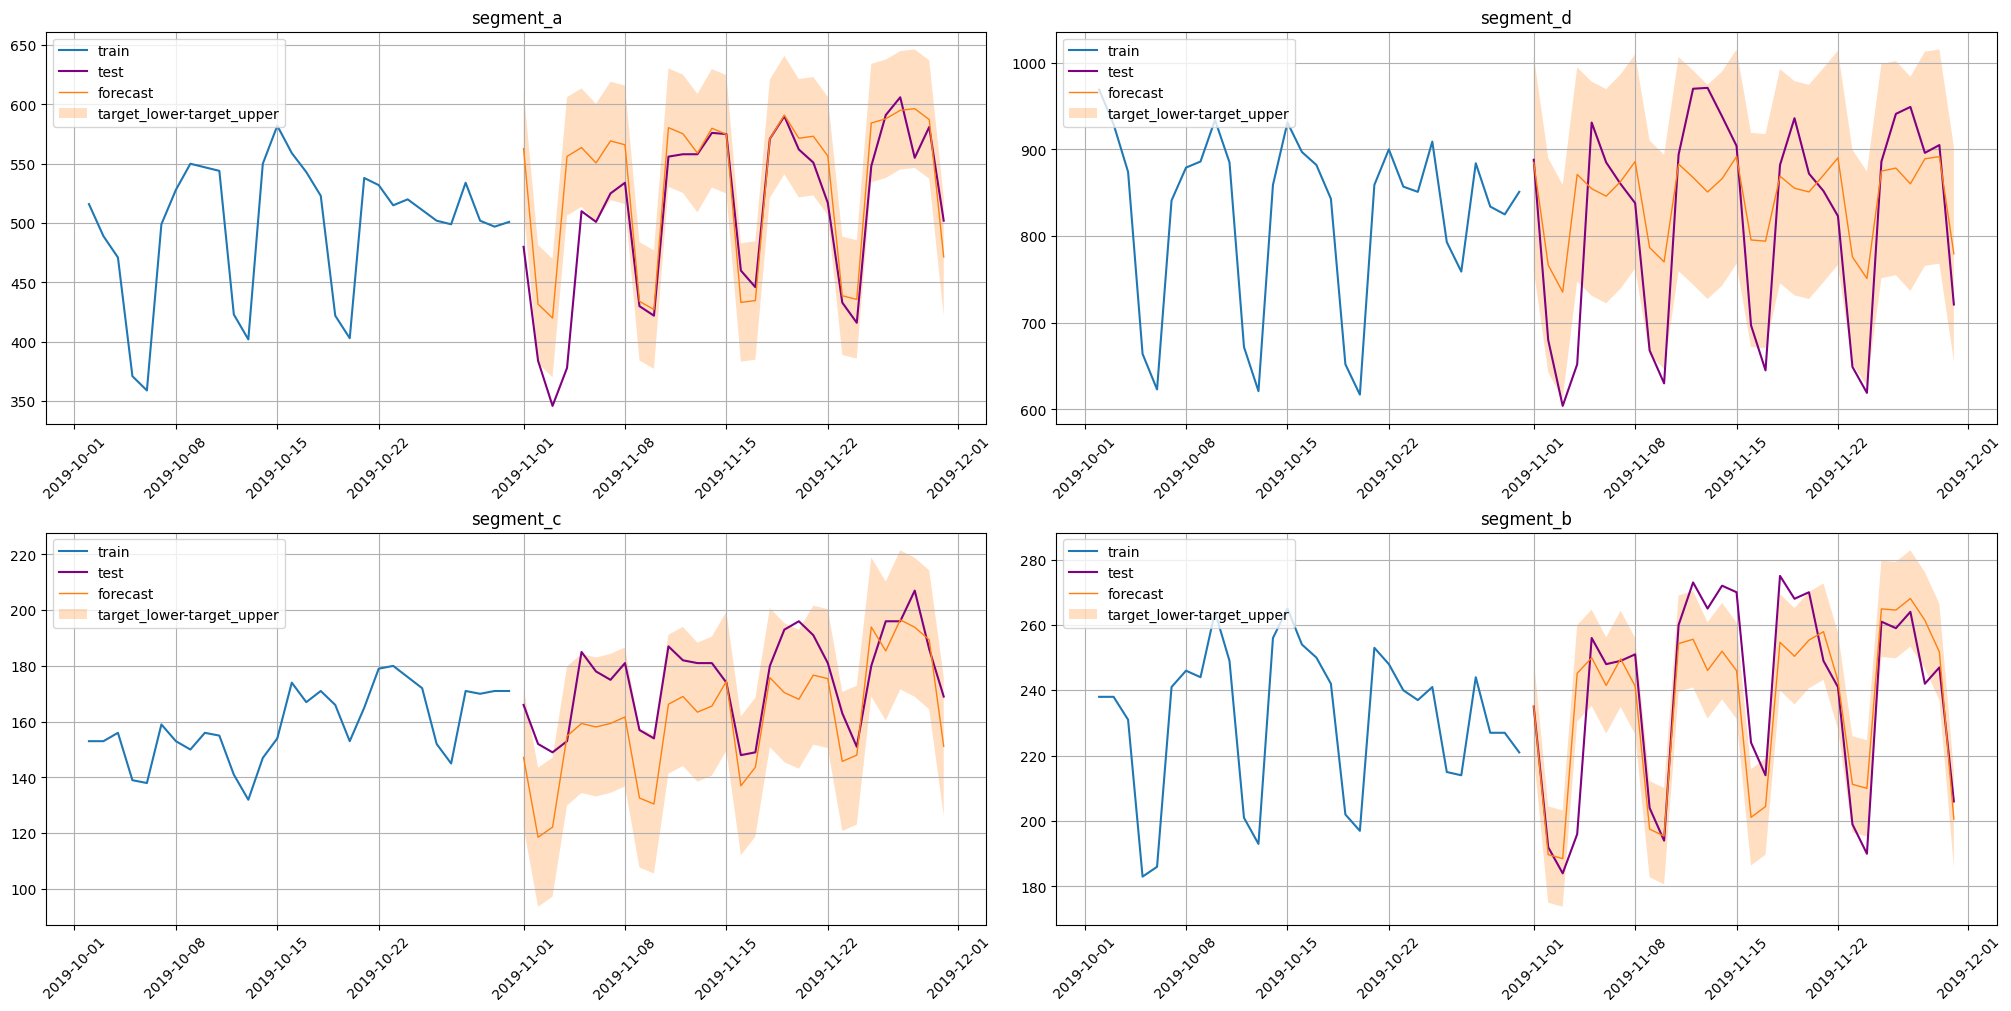

In [53]:
plot_forecast(forecast, test_ts, train_ts, prediction_intervals=True, n_train_samples=30)

In [54]:
coverage, width = interval_metrics(test_ts=test_ts, forecast=forecast)

In [55]:
coverage

{'segment_a': 0.8666666666666667,
 'segment_b': 0.6666666666666666,
 'segment_c': 0.8666666666666667,
 'segment_d': 0.8}

In [56]:
width

{'segment_a': 99.74407563536734,
 'segment_b': 29.46380276236236,
 'segment_c': 49.833980779974766,
 'segment_d': 247.16834782574568}